# Load libraries

In [1]:
# Load required libraries
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.metrics import dtw
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
import copy
import sails
import umap.umap_ as umap

# Import custom functions
from functions import *
from Artefacts_Detection import *

# sns.set(style='white', context='notebook')

In [252]:
# Loading sleep scoring data from MAT files stored in Google Drive.
# path_to_data = '/content/drive/My Drive/Donders Internship/2018-07-26_14-20-46_Post-Trial5/'
# data_file = 'PFClfpCleaned.mat'
# states_file = '2018-07-26_14-20-46_Post-Trial5-states.mat'

path_to_data = "./data/2018-07-26_14-20-46_Post-Trial5/"
data_file = 'Cleaned_PFC_100_CH52_0.continuous.mat'
states_file = '2018-07-26_14-20-46_Post-Trial5-states.mat'
pfc_data, sleep_scoring = load_mat_data(path_to_data, data_file, states_file)

In [253]:
delta_cycle_data_2018_07_26_trial5 = get_delta_cycles(pfc_data, sleep_scoring, fs=1000)

C:\anaconda3\Lib\site-packages\neurodsp\filt\utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


 Checking Cycles inputs - trimming singleton from input 'IP'


In [254]:
metrics1 = delta_cycle_data_2018_07_26_trial5['cycles'].get_metric_dataframe()

metrics_2018_07_26_trial5 = pd.concat([metrics1])
# all_trials_metrics = metrics5

trough = 60
peak = 85
delta_peak = 40

peak_thresh = np.percentile(metrics_2018_07_26_trial5['peak_values'], peak)
trough_thresh = np.percentile(metrics_2018_07_26_trial5['trough_values'], trough)
delta_peak_thresh = np.percentile(metrics_2018_07_26_trial5['peak_values'], delta_peak)

lo_freq_duration = delta_cycle_data_2018_07_26_trial5['fs']/0.1
hi_freq_duration = delta_cycle_data_2018_07_26_trial5['fs']/4

In [255]:
# Apply conditions to get good cycles
conditions_all_cycles = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'trough_values<={trough_thresh}']

conditions_so_cycles = ['is_good==1',
          f'duration_samples<{lo_freq_duration}',
          f'duration_samples>{hi_freq_duration}',
          f'peak_values>={peak_thresh}',
          f'trough_values<={trough_thresh}']

conditions_delta_cycles = ['is_good==1',
          f'duration_samples<{lo_freq_duration}',
          f'duration_samples>{hi_freq_duration}',
          f'peak_values<{peak_thresh}',
          f'trough_values<={trough_thresh}']

all_cycles_trial5 = get_cycles_with_conditions(delta_cycle_data_2018_07_26_trial5['cycles'], conditions_all_cycles)

so_cycles_trial5 = get_cycles_with_conditions(delta_cycle_data_2018_07_26_trial5['cycles'], conditions_so_cycles)

delta_cycles_trial5 = get_cycles_with_conditions(delta_cycle_data_2018_07_26_trial5['cycles'], conditions_delta_cycles)

In [256]:
conditions_big_delta_cycles = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              f'peak_values>{delta_peak_thresh}']

conditions_small_delta_cycles = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              f'peak_values<={delta_peak_thresh}']

big_delta_cycles_trial5 = get_cycles_with_conditions(delta_cycles_2018_07_26_trial5, conditions_big_delta_cycles)
small_delta_cycles_trial5 = get_cycles_with_conditions(delta_cycles_2018_07_26_trial5, conditions_small_delta_cycles)

In [257]:
all_waveforms_trial5, _ = emd.cycles.phase_align(delta_cycle_data_2018_07_26_trial5['IP'], delta_cycle_data_2018_07_26_trial5['nrem_filtered_data'],
                                                            cycles=all_cycles_trial5.iterate(through='subset'), npoints=50)

so_waveforms_trial5, _ = emd.cycles.phase_align(delta_cycle_data_2018_07_26_trial5['IP'], delta_cycle_data_2018_07_26_trial5['nrem_filtered_data'],
                                                            cycles=so_cycles_trial5.iterate(through='subset'), npoints=50)

delta_waveforms_trial5, _ = emd.cycles.phase_align(delta_cycle_data_2018_07_26_trial5['IP'], delta_cycle_data_2018_07_26_trial5['nrem_filtered_data'],
                                                            cycles=delta_cycles_trial5.iterate(through='subset'), npoints=50)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'


In [258]:
big_delta_waveforms_trial5, _ = emd.cycles.phase_align(delta_cycle_data_2018_07_26_trial5['IP'], delta_cycle_data_2018_07_26_trial5['nrem_filtered_data'],
                                                            cycles=big_delta_cycles_trial5.iterate(through='subset'), npoints=50)
small_delta_waveforms_trial5, _ = emd.cycles.phase_align(delta_cycle_data_2018_07_26_trial5['IP'], delta_cycle_data_2018_07_26_trial5['nrem_filtered_data'],
                                                            cycles=small_delta_cycles_trial5.iterate(through='subset'), npoints=50)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'


(-1000.0, 7000.0)

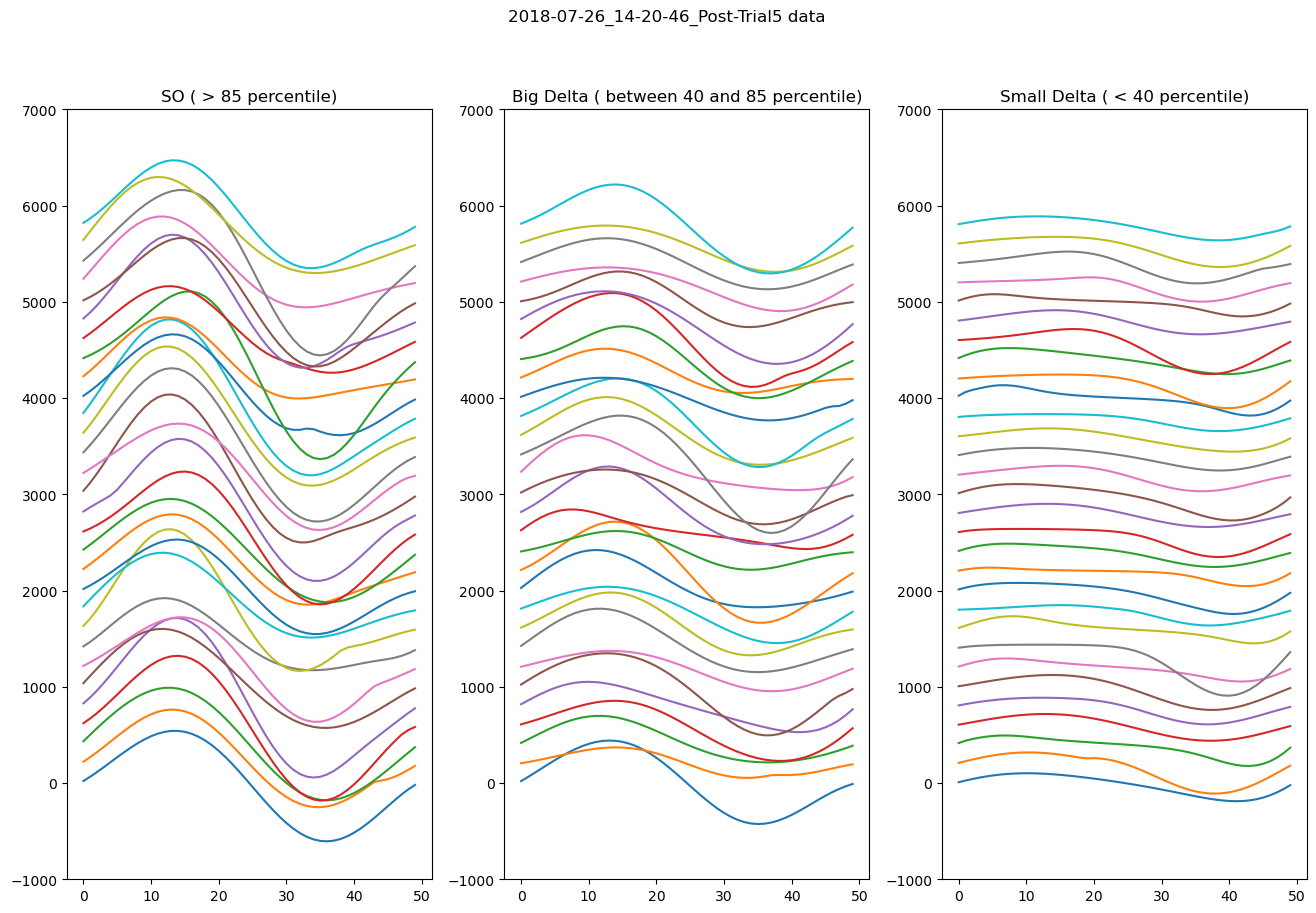

In [259]:
plt.figure(figsize=(16,10), facecolor='white')
plt.suptitle("2018-07-26_14-20-46_Post-Trial5 data")
plt.subplot(1, 3, 1)
plt.title('SO ( > 85 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, so_waveforms_trial5.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(so_waveforms_trial5[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

# plt.subplot(1, 4, 2)
# plt.title('Delta (< 85 percentile)')
# # plt.yticks([])
# start = 0
# cycles_to_plot = np.random.randint(1, OS_delta_waveforms_trial5.shape[1], 30)
# for i in cycles_to_plot:
#   plt.plot(OS_delta_waveforms_trial5[:,i]+start)
#   start += 200
# plt.ylim((-1000, 7000))

plt.subplot(1, 3, 2)
plt.title('Big Delta ( between 40 and 85 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, big_delta_waveforms_trial5.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(big_delta_waveforms_trial5[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

plt.subplot(1, 3, 3)
plt.title('Small Delta ( < 40 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, small_delta_waveforms_trial5.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(small_delta_waveforms_trial5[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

# plt.savefig('Phase-align-cycles.svg')

(-1000.0, 7000.0)

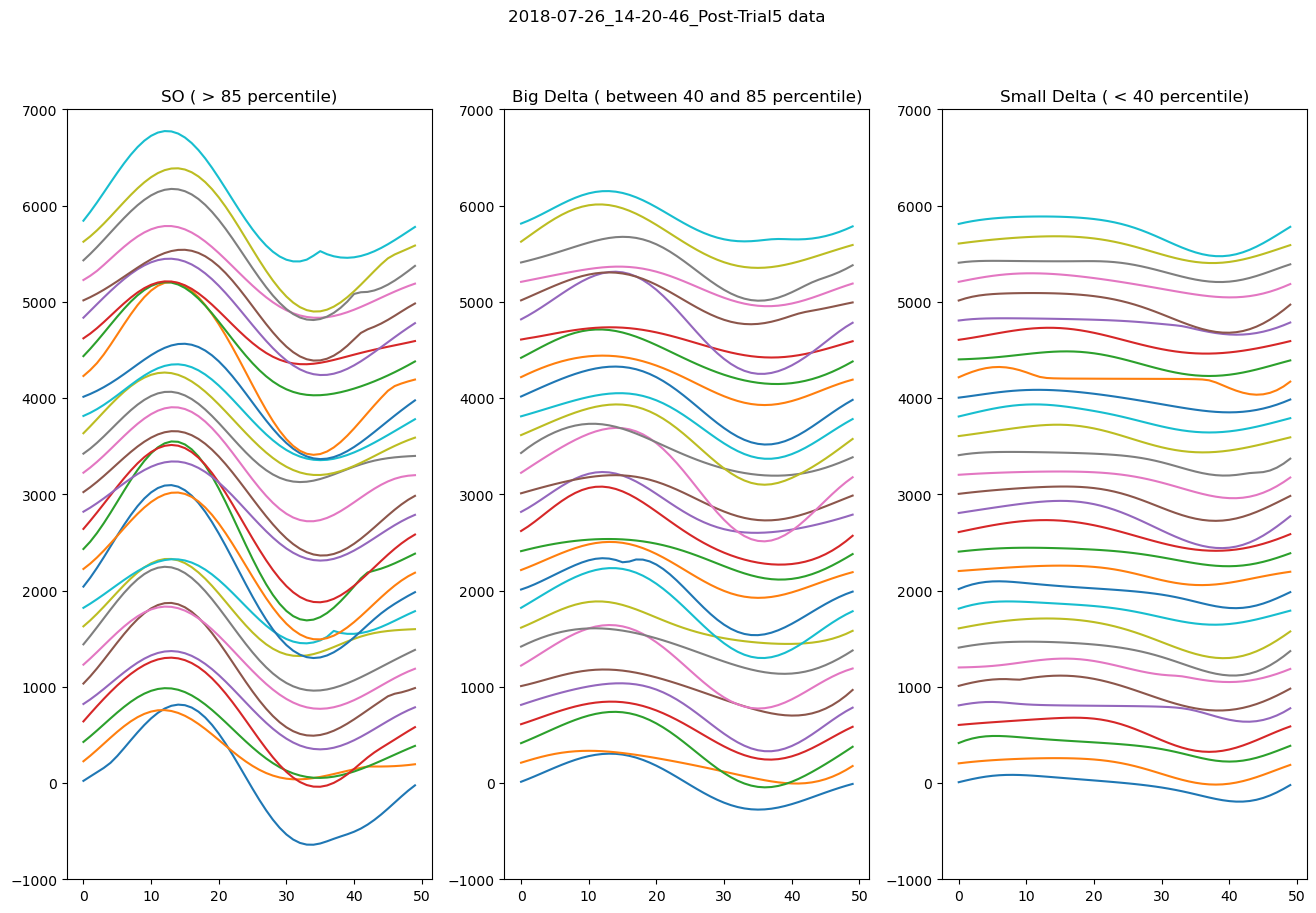

In [251]:
plt.figure(figsize=(16,10), facecolor='white')
plt.suptitle("2018-07-26_14-20-46_Post-Trial5 data")
plt.subplot(1, 3, 1)
plt.title('SO ( > 85 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, so_waveforms_trial5.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(so_waveforms_trial5[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

# plt.subplot(1, 4, 2)
# plt.title('Delta (< 85 percentile)')
# # plt.yticks([])
# start = 0
# cycles_to_plot = np.random.randint(1, OS_delta_waveforms_trial5.shape[1], 30)
# for i in cycles_to_plot:
#   plt.plot(OS_delta_waveforms_trial5[:,i]+start)
#   start += 200
# plt.ylim((-1000, 7000))

plt.subplot(1, 3, 2)
plt.title('Big Delta ( between 40 and 85 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, big_delta_waveforms_trial5.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(big_delta_waveforms_trial5[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

plt.subplot(1, 3, 3)
plt.title('Small Delta ( < 40 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, small_delta_waveforms_trial5.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(small_delta_waveforms_trial5[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

# plt.savefig('Phase-align-cycles.svg')

# Extract Cycles data

In [2]:
def get_delta_cycles(pfc_data, sleep_scoring, fs=1000):
    # Get filtered NREM LFP data
    nrem_epochs = np.array(get_all_NREM_epochs(sleep_scoring))
    nrem_filtered_data, nrem_data = get_nrem_filtered(pfc_data, nrem_epochs, fs=fs)

    # Get cycles using IP
    IP, IF, IA = emd.spectra.frequency_transform(nrem_filtered_data, fs, 'hilbert')
    C = emd.cycles.Cycles(IP)
    cycles = get_cycles_with_metrics(C, nrem_filtered_data, IA, IF)
    
    delta_cycle_data = {"fs": fs, 'nrem_epochs': nrem_epochs, 'nrem_filtered_data': nrem_filtered_data,
                       "IP": IP, "IF": IF, "IP": IP, "cycles": cycles}
    return delta_cycle_data

# OS_basic_13_CN

In [3]:
path_to_data = './data/OS_basic_13_CN/'
data_file = 'Cleaned_Trial1_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-13_11-24-48_post_trial1-states.mat'
pfc_data1, sleep_scoring1 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial2_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-13_12-15-25_post_trial2-states.mat'
pfc_data2, sleep_scoring2 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial3_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-13_13-05-57_post_trial3-states.mat'
pfc_data3, sleep_scoring3 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial4_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-13_13-56-29_post_trial4-states.mat'
pfc_data4, sleep_scoring4 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial5_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-13_14-53-54_post_trial5-states.mat'
pfc_data5, sleep_scoring5 = load_mat_data(path_to_data, data_file, states_file)

In [4]:
OS_delta_cycle_data_trial1 = get_delta_cycles(pfc_data1, sleep_scoring1, fs=2500)
OS_delta_cycle_data_trial2 = get_delta_cycles(pfc_data2, sleep_scoring2, fs=2500)
OS_delta_cycle_data_trial3 = get_delta_cycles(pfc_data3, sleep_scoring3, fs=2500)
OS_delta_cycle_data_trial4 = get_delta_cycles(pfc_data4, sleep_scoring4, fs=2500)
OS_delta_cycle_data_trial5 = get_delta_cycles(pfc_data5, sleep_scoring5, fs=2500)

C:\anaconda3\Lib\site-packages\neurodsp\filt\utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'


In [184]:
metrics1 = OS_delta_cycle_data_trial1['cycles'].get_metric_dataframe()
metrics2 = OS_delta_cycle_data_trial2['cycles'].get_metric_dataframe()
metrics3 = OS_delta_cycle_data_trial3['cycles'].get_metric_dataframe()
metrics4 = OS_delta_cycle_data_trial4['cycles'].get_metric_dataframe()
metrics5 = OS_delta_cycle_data_trial5['cycles'].get_metric_dataframe()

OS_all_trials_metrics = pd.concat([metrics1, metrics2, metrics3, metrics4, metrics5])
# all_trials_metrics = metrics5

trough = 60
peak = 80
delta_peak = 40

peak_thresh = np.percentile(OS_all_trials_metrics['peak_values'], peak)
trough_thresh = np.percentile(OS_all_trials_metrics['trough_values'], trough)
delta_peak_thresh = np.percentile(OS_all_trials_metrics['peak_values'], delta_peak)

lo_freq_duration = OS_delta_cycle_data_trial5['fs']/0.1
hi_freq_duration = OS_delta_cycle_data_trial5['fs']/4

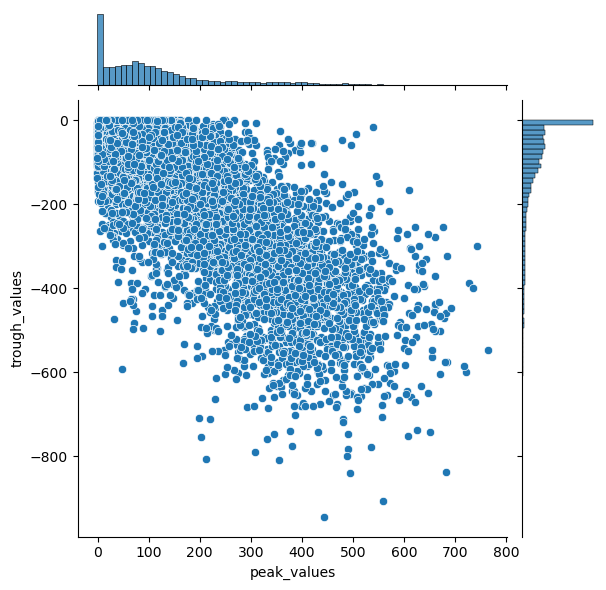

In [185]:
sns.jointplot(x=OS_all_trials_metrics['peak_values'], y=OS_all_trials_metrics['trough_values'])

# ==============================================

In [ ]:
scaled_data = StandardScaler().fit_transform(metrics[['peak_values', 'trough_values']])

pca_combined = PCA(n_components=2)
pca_combined.fit(scaled_data)
components_combined = pd.DataFrame(pca_combined.transform(scaled_data))
components_combined.columns = [f'PC-{i}' for i in range(1,3)]

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(components_combined)

In [ ]:
y_pred = kmeans.predict(components_combined)
df = pd.concat([components_combined, pd.DataFrame({"Group": y_pred})], axis=1)
sns.pairplot(df, hue='Group')

# ==============================================

In [186]:
# Apply conditions to get good cycles
conditions_all_cycles = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'trough_values<={trough_thresh}']

conditions_so_cycles = ['is_good==1',
          f'duration_samples<{lo_freq_duration}',
          f'duration_samples>{hi_freq_duration}',
          f'peak_values>={peak_thresh}',
          f'trough_values<={trough_thresh}']

conditions_delta_cycles = ['is_good==1',
          f'duration_samples<{lo_freq_duration}',
          f'duration_samples>{hi_freq_duration}',
          f'peak_values<{peak_thresh}',
          f'trough_values<={trough_thresh}']

# all_cycles_trial1 = get_cycles_with_conditions(delta_cycle_data_trial1['cycles'], conditions_all_cycles)
# all_cycles_trial2 = get_cycles_with_conditions(delta_cycle_data_trial2['cycles'], conditions_all_cycles)
# all_cycles_trial3 = get_cycles_with_conditions(delta_cycle_data_trial3['cycles'], conditions_all_cycles)
# all_cycles_trial4 = get_cycles_with_conditions(delta_cycle_data_trial4['cycles'], conditions_all_cycles)
OS_all_cycles_trial5 = get_cycles_with_conditions(OS_delta_cycle_data_trial5['cycles'], conditions_all_cycles)

# so_cycles_trial1 = get_cycles_with_conditions(delta_cycle_data_trial1['cycles'], conditions_so_cycles)
# so_cycles_trial2 = get_cycles_with_conditions(delta_cycle_data_trial2['cycles'], conditions_so_cycles)
# so_cycles_trial3 = get_cycles_with_conditions(delta_cycle_data_trial3['cycles'], conditions_so_cycles)
# so_cycles_trial4 = get_cycles_with_conditions(delta_cycle_data_trial4['cycles'], conditions_so_cycles)
OS_so_cycles_trial5 = get_cycles_with_conditions(OS_delta_cycle_data_trial5['cycles'], conditions_so_cycles)

# delta_cycles_trial1 = get_cycles_with_conditions(delta_cycle_data_trial1['cycles'], conditions_delta_cycles)
# delta_cycles_trial2 = get_cycles_with_conditions(delta_cycle_data_trial2['cycles'], conditions_delta_cycles)
# delta_cycles_trial3 = get_cycles_with_conditions(delta_cycle_data_trial3['cycles'], conditions_delta_cycles)
# delta_cycles_trial4 = get_cycles_with_conditions(delta_cycle_data_trial4['cycles'], conditions_delta_cycles)
OS_delta_cycles_trial5 = get_cycles_with_conditions(OS_delta_cycle_data_trial5['cycles'], conditions_delta_cycles)

In [187]:
conditions_big_delta_cycles = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              f'peak_values>{delta_peak_thresh}']

conditions_small_delta_cycles = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              f'peak_values<={delta_peak_thresh}']

OS_big_delta_cycles_trial5 = get_cycles_with_conditions(OS_delta_cycles_trial5, conditions_big_delta_cycles)
OS_small_delta_cycles_trial5 = get_cycles_with_conditions(OS_delta_cycles_trial5, conditions_small_delta_cycles)

## Phase-aligned Cycles

In [188]:
# all_waveforms_trial1, _ = emd.cycles.phase_align(delta_cycle_data_trial1['IP'], delta_cycle_data_trial1['nrem_filtered_data'],
#                                                             cycles=all_cycles_trial1.iterate(through='subset'), npoints=50)
# all_waveforms_trial2, _ = emd.cycles.phase_align(delta_cycle_data_trial2['IP'], delta_cycle_data_trial2['nrem_filtered_data'],
#                                                             cycles=all_cycles_trial2.iterate(through='subset'), npoints=50)
# all_waveforms_trial3, _ = emd.cycles.phase_align(delta_cycle_data_trial3['IP'], delta_cycle_data_trial3['nrem_filtered_data'],
#                                                             cycles=all_cycles_trial3.iterate(through='subset'), npoints=50)
# all_waveforms_trial4, _ = emd.cycles.phase_align(delta_cycle_data_trial4['IP'], delta_cycle_data_trial4['nrem_filtered_data'],
#                                                             cycles=all_cycles_trial4.iterate(through='subset'), npoints=50)
OS_all_waveforms_trial5, _ = emd.cycles.phase_align(OS_delta_cycle_data_trial5['IP'], OS_delta_cycle_data_trial5['nrem_filtered_data'],
                                                            cycles=OS_all_cycles_trial5.iterate(through='subset'), npoints=50)


# so_waveforms_trial1, _ = emd.cycles.phase_align(delta_cycle_data_trial1['IP'], delta_cycle_data_trial1['nrem_filtered_data'],
#                                                             cycles=so_cycles_trial1.iterate(through='subset'), npoints=50)
# so_waveforms_trial2, _ = emd.cycles.phase_align(delta_cycle_data_trial2['IP'], delta_cycle_data_trial2['nrem_filtered_data'],
#                                                             cycles=so_cycles_trial2.iterate(through='subset'), npoints=50)
# so_waveforms_trial3, _ = emd.cycles.phase_align(delta_cycle_data_trial3['IP'], delta_cycle_data_trial3['nrem_filtered_data'],
#                                                             cycles=so_cycles_trial3.iterate(through='subset'), npoints=50)
# so_waveforms_trial4, _ = emd.cycles.phase_align(delta_cycle_data_trial4['IP'], delta_cycle_data_trial4['nrem_filtered_data'],
#                                                             cycles=so_cycles_trial4.iterate(through='subset'), npoints=50)
OS_so_waveforms_trial5, _ = emd.cycles.phase_align(OS_delta_cycle_data_trial5['IP'], OS_delta_cycle_data_trial5['nrem_filtered_data'],
                                                            cycles=OS_so_cycles_trial5.iterate(through='subset'), npoints=50)

# delta_waveforms_trial1, _ = emd.cycles.phase_align(delta_cycle_data_trial1['IP'], delta_cycle_data_trial1['nrem_filtered_data'],
#                                                             cycles=delta_cycles_trial1.iterate(through='subset'), npoints=50)
# delta_waveforms_trial2, _ = emd.cycles.phase_align(delta_cycle_data_trial2['IP'], delta_cycle_data_trial2['nrem_filtered_data'],
#                                                             cycles=delta_cycles_trial2.iterate(through='subset'), npoints=50)
# delta_waveforms_trial3, _ = emd.cycles.phase_align(delta_cycle_data_trial3['IP'], delta_cycle_data_trial3['nrem_filtered_data'],
#                                                             cycles=delta_cycles_trial3.iterate(through='subset'), npoints=50)
# delta_waveforms_trial4, _ = emd.cycles.phase_align(delta_cycle_data_trial4['IP'], delta_cycle_data_trial4['nrem_filtered_data'],
#                                                             cycles=delta_cycles_trial4.iterate(through='subset'), npoints=50)
OS_delta_waveforms_trial5, _ = emd.cycles.phase_align(OS_delta_cycle_data_trial5['IP'], OS_delta_cycle_data_trial5['nrem_filtered_data'],
                                                            cycles=OS_delta_cycles_trial5.iterate(through='subset'), npoints=50)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'


In [189]:
OS_big_delta_waveforms_trial5, _ = emd.cycles.phase_align(OS_delta_cycle_data_trial5['IP'], OS_delta_cycle_data_trial5['nrem_filtered_data'],
                                                            cycles=OS_big_delta_cycles_trial5.iterate(through='subset'), npoints=50)
OS_small_delta_waveforms_trial5, _ = emd.cycles.phase_align(OS_delta_cycle_data_trial5['IP'], OS_delta_cycle_data_trial5['nrem_filtered_data'],
                                                            cycles=OS_small_delta_cycles_trial5.iterate(through='subset'), npoints=50)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'


(-1000.0, 7000.0)

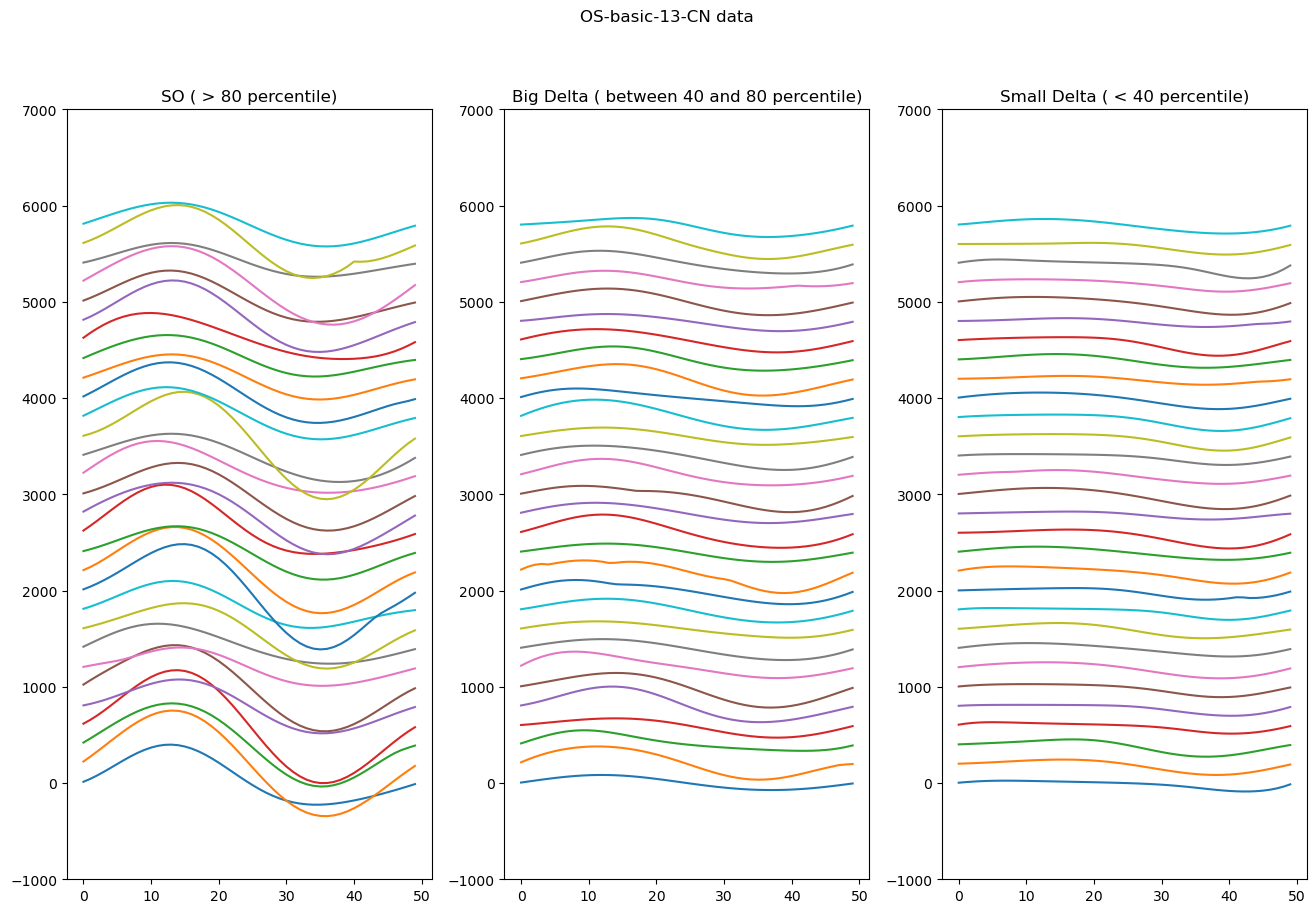

In [191]:
plt.figure(figsize=(16,10), facecolor='white')
plt.suptitle("OS-basic-13-CN data")
plt.subplot(1, 3, 1)
plt.title('SO ( > 80 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, OS_so_waveforms_trial5.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(OS_so_waveforms_trial5[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

# plt.subplot(1, 4, 2)
# plt.title('Delta (< 85 percentile)')
# # plt.yticks([])
# start = 0
# cycles_to_plot = np.random.randint(1, OS_delta_waveforms_trial5.shape[1], 30)
# for i in cycles_to_plot:
#   plt.plot(OS_delta_waveforms_trial5[:,i]+start)
#   start += 200
# plt.ylim((-1000, 7000))

plt.subplot(1, 3, 2)
plt.title('Big Delta ( between 40 and 80 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, OS_big_delta_waveforms_trial5.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(OS_big_delta_waveforms_trial5[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

plt.subplot(1, 3, 3)
plt.title('Small Delta ( < 40 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, OS_small_delta_waveforms_trial5.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(OS_small_delta_waveforms_trial5[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

# plt.savefig('Phase-align-cycles.svg')

# Get cycle subsets according to Thresholds (CBD)

In [ ]:
path_to_data = './data/CBD_5_SD4/'
data_file = 'Cleaned_Trial1_PFC_100_CH12_0.continuous.mat'
states_file = '2021-07-16_11-23-25_posttrial1-states_ES.mat'
pfc_data1, sleep_scoring1 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial2_PFC_100_CH12_0.continuous.mat'
states_file = '2021-07-16_12-13-39_posttrial2-states_ES.mat'
pfc_data2, sleep_scoring2 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial3_PFC_100_CH12_0.continuous.mat'
states_file = '2021-07-16_13-09-26_posttrial3-states_ES.mat'
pfc_data3, sleep_scoring3 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial4_PFC_100_CH12_0.continuous.mat'
states_file = '2021-07-16_13-59-43_posttrial4-states_ES.mat'
pfc_data4, sleep_scoring4 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial5_PFC_100_CH12_0.continuous.mat'
states_file = '2021-07-16_14-49-56_posttrial5-states_ES.mat'
pfc_data5, sleep_scoring5 = load_mat_data(path_to_data, data_file, states_file)

In [107]:
len(pfc_data5)/len(sleep_scoring5)

2500.1955555555555

In [108]:
CBD_delta_cycle_data_trial1 = get_delta_cycles(pfc_data1, sleep_scoring1, fs=2500)
CBD_delta_cycle_data_trial2 = get_delta_cycles(pfc_data2, sleep_scoring2, fs=2500)
CBD_delta_cycle_data_trial3 = get_delta_cycles(pfc_data3, sleep_scoring3, fs=2500)
CBD_delta_cycle_data_trial4 = get_delta_cycles(pfc_data4, sleep_scoring4, fs=2500)
CBD_delta_cycle_data_trial5 = get_delta_cycles(pfc_data5, sleep_scoring5, fs=2500)

C:\anaconda3\Lib\site-packages\neurodsp\filt\utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'


In [177]:
metrics1 = CBD_delta_cycle_data_trial1['cycles'].get_metric_dataframe()
metrics2 = CBD_delta_cycle_data_trial2['cycles'].get_metric_dataframe()
metrics3 = CBD_delta_cycle_data_trial3['cycles'].get_metric_dataframe()
metrics4 = CBD_delta_cycle_data_trial4['cycles'].get_metric_dataframe()
metrics5 = CBD_delta_cycle_data_trial5['cycles'].get_metric_dataframe()

CBD_all_trials_metrics = pd.concat([metrics1, metrics2, metrics3, metrics4, metrics5])
# all_trials_metrics = metrics5

trough = 60
peak = 80
delta_peak = 40

peak_thresh = np.percentile(CBD_all_trials_metrics['peak_values'], peak)
trough_thresh = np.percentile(CBD_all_trials_metrics['trough_values'], trough)
delta_peak_thresh = np.percentile(CBD_all_trials_metrics['peak_values'], delta_peak)

lo_freq_duration = CBD_delta_cycle_data_trial5['fs']/0.1
hi_freq_duration = CBD_delta_cycle_data_trial5['fs']/4

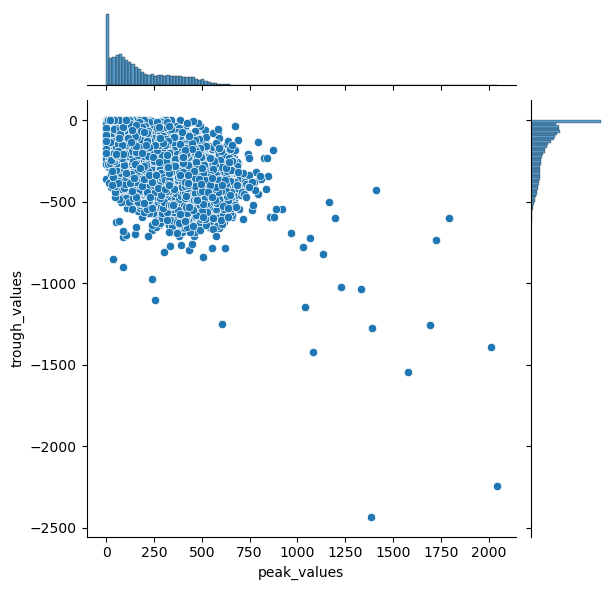

In [178]:
sns.jointplot(x=CBD_all_trials_metrics['peak_values'], y=CBD_all_trials_metrics['trough_values'])

In [179]:
# Apply conditions to get good cycles
conditions_all_cycles = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'trough_values<={trough_thresh}']

conditions_so_cycles = ['is_good==1',
          f'duration_samples<{lo_freq_duration}',
          f'duration_samples>{hi_freq_duration}',
          f'peak_values>={peak_thresh}',
          f'trough_values<={trough_thresh}']

conditions_delta_cycles = ['is_good==1',
          f'duration_samples<{lo_freq_duration}',
          f'duration_samples>{hi_freq_duration}',
          f'peak_values<{peak_thresh}',
          f'trough_values<={trough_thresh}']

# all_cycles_trial1 = get_cycles_with_conditions(delta_cycle_data_trial1['cycles'], conditions_all_cycles)
# all_cycles_trial2 = get_cycles_with_conditions(delta_cycle_data_trial2['cycles'], conditions_all_cycles)
# all_cycles_trial3 = get_cycles_with_conditions(delta_cycle_data_trial3['cycles'], conditions_all_cycles)
# all_cycles_trial4 = get_cycles_with_conditions(delta_cycle_data_trial4['cycles'], conditions_all_cycles)
CBD_all_cycles_trial5 = get_cycles_with_conditions(CBD_delta_cycle_data_trial5['cycles'], conditions_all_cycles)

# so_cycles_trial1 = get_cycles_with_conditions(delta_cycle_data_trial1['cycles'], conditions_so_cycles)
# so_cycles_trial2 = get_cycles_with_conditions(delta_cycle_data_trial2['cycles'], conditions_so_cycles)
# so_cycles_trial3 = get_cycles_with_conditions(delta_cycle_data_trial3['cycles'], conditions_so_cycles)
# so_cycles_trial4 = get_cycles_with_conditions(delta_cycle_data_trial4['cycles'], conditions_so_cycles)
CBD_so_cycles_trial5 = get_cycles_with_conditions(CBD_delta_cycle_data_trial5['cycles'], conditions_so_cycles)

# delta_cycles_trial1 = get_cycles_with_conditions(delta_cycle_data_trial1['cycles'], conditions_delta_cycles)
# delta_cycles_trial2 = get_cycles_with_conditions(delta_cycle_data_trial2['cycles'], conditions_delta_cycles)
# delta_cycles_trial3 = get_cycles_with_conditions(delta_cycle_data_trial3['cycles'], conditions_delta_cycles)
# delta_cycles_trial4 = get_cycles_with_conditions(delta_cycle_data_trial4['cycles'], conditions_delta_cycles)
CBD_delta_cycles_trial5 = get_cycles_with_conditions(CBD_delta_cycle_data_trial5['cycles'], conditions_delta_cycles)

In [180]:
conditions_big_delta_cycles = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              f'peak_values>{delta_peak_thresh}']

conditions_small_delta_cycles = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              f'peak_values<={delta_peak_thresh}']

CBD_big_delta_cycles_trial5 = get_cycles_with_conditions(CBD_delta_cycles_trial5, conditions_big_delta_cycles)
CBD_small_delta_cycles_trial5 = get_cycles_with_conditions(CBD_delta_cycles_trial5, conditions_small_delta_cycles)

## Phase-aligned Cycles

In [181]:
# all_waveforms_trial1, _ = emd.cycles.phase_align(delta_cycle_data_trial1['IP'], delta_cycle_data_trial1['nrem_filtered_data'],
#                                                             cycles=all_cycles_trial1.iterate(through='subset'), npoints=100)
# all_waveforms_trial2, _ = emd.cycles.phase_align(delta_cycle_data_trial2['IP'], delta_cycle_data_trial2['nrem_filtered_data'],
#                                                             cycles=all_cycles_trial2.iterate(through='subset'), npoints=100)
# all_waveforms_trial3, _ = emd.cycles.phase_align(delta_cycle_data_trial3['IP'], delta_cycle_data_trial3['nrem_filtered_data'],
#                                                             cycles=all_cycles_trial3.iterate(through='subset'), npoints=100)
# all_waveforms_trial4, _ = emd.cycles.phase_align(delta_cycle_data_trial4['IP'], delta_cycle_data_trial4['nrem_filtered_data'],
#                                                             cycles=all_cycles_trial4.iterate(through='subset'), npoints=100)
CBD_all_waveforms_trial5, _ = emd.cycles.phase_align(CBD_delta_cycle_data_trial5['IP'], CBD_delta_cycle_data_trial5['nrem_filtered_data'],
                                                            cycles=CBD_all_cycles_trial5.iterate(through='subset'), npoints=50)


# so_waveforms_trial1, _ = emd.cycles.phase_align(delta_cycle_data_trial1['IP'], delta_cycle_data_trial1['nrem_filtered_data'],
#                                                             cycles=so_cycles_trial1.iterate(through='subset'), npoints=100)
# so_waveforms_trial2, _ = emd.cycles.phase_align(delta_cycle_data_trial2['IP'], delta_cycle_data_trial2['nrem_filtered_data'],
#                                                             cycles=so_cycles_trial2.iterate(through='subset'), npoints=100)
# so_waveforms_trial3, _ = emd.cycles.phase_align(delta_cycle_data_trial3['IP'], delta_cycle_data_trial3['nrem_filtered_data'],
#                                                             cycles=so_cycles_trial3.iterate(through='subset'), npoints=100)
# so_waveforms_trial4, _ = emd.cycles.phase_align(delta_cycle_data_trial4['IP'], delta_cycle_data_trial4['nrem_filtered_data'],
#                                                             cycles=so_cycles_trial4.iterate(through='subset'), npoints=100)
CBD_so_waveforms_trial5, _ = emd.cycles.phase_align(CBD_delta_cycle_data_trial5['IP'], CBD_delta_cycle_data_trial5['nrem_filtered_data'],
                                                            cycles=CBD_so_cycles_trial5.iterate(through='subset'), npoints=50)

# delta_waveforms_trial1, _ = emd.cycles.phase_align(delta_cycle_data_trial1['IP'], delta_cycle_data_trial1['nrem_filtered_data'],
#                                                             cycles=delta_cycles_trial1.iterate(through='subset'), npoints=100)
# delta_waveforms_trial2, _ = emd.cycles.phase_align(delta_cycle_data_trial2['IP'], delta_cycle_data_trial2['nrem_filtered_data'],
#                                                             cycles=delta_cycles_trial2.iterate(through='subset'), npoints=100)
# delta_waveforms_trial3, _ = emd.cycles.phase_align(delta_cycle_data_trial3['IP'], delta_cycle_data_trial3['nrem_filtered_data'],
#                                                             cycles=delta_cycles_trial3.iterate(through='subset'), npoints=100)
# delta_waveforms_trial4, _ = emd.cycles.phase_align(delta_cycle_data_trial4['IP'], delta_cycle_data_trial4['nrem_filtered_data'],
#                                                             cycles=delta_cycles_trial4.iterate(through='subset'), npoints=100)
CBD_delta_waveforms_trial5, _ = emd.cycles.phase_align(CBD_delta_cycle_data_trial5['IP'], CBD_delta_cycle_data_trial5['nrem_filtered_data'],
                                                            cycles=CBD_delta_cycles_trial5.iterate(through='subset'), npoints=50)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'


In [182]:
CBD_big_delta_waveforms_trial5, _ = emd.cycles.phase_align(CBD_delta_cycle_data_trial5['IP'], CBD_delta_cycle_data_trial5['nrem_filtered_data'],
                                                            cycles=CBD_big_delta_cycles_trial5.iterate(through='subset'), npoints=50)
CBD_small_delta_waveforms_trial5, _ = emd.cycles.phase_align(CBD_delta_cycle_data_trial5['IP'], CBD_delta_cycle_data_trial5['nrem_filtered_data'],
                                                            cycles=CBD_small_delta_cycles_trial5.iterate(through='subset'), npoints=50)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'


(-1000.0, 7000.0)

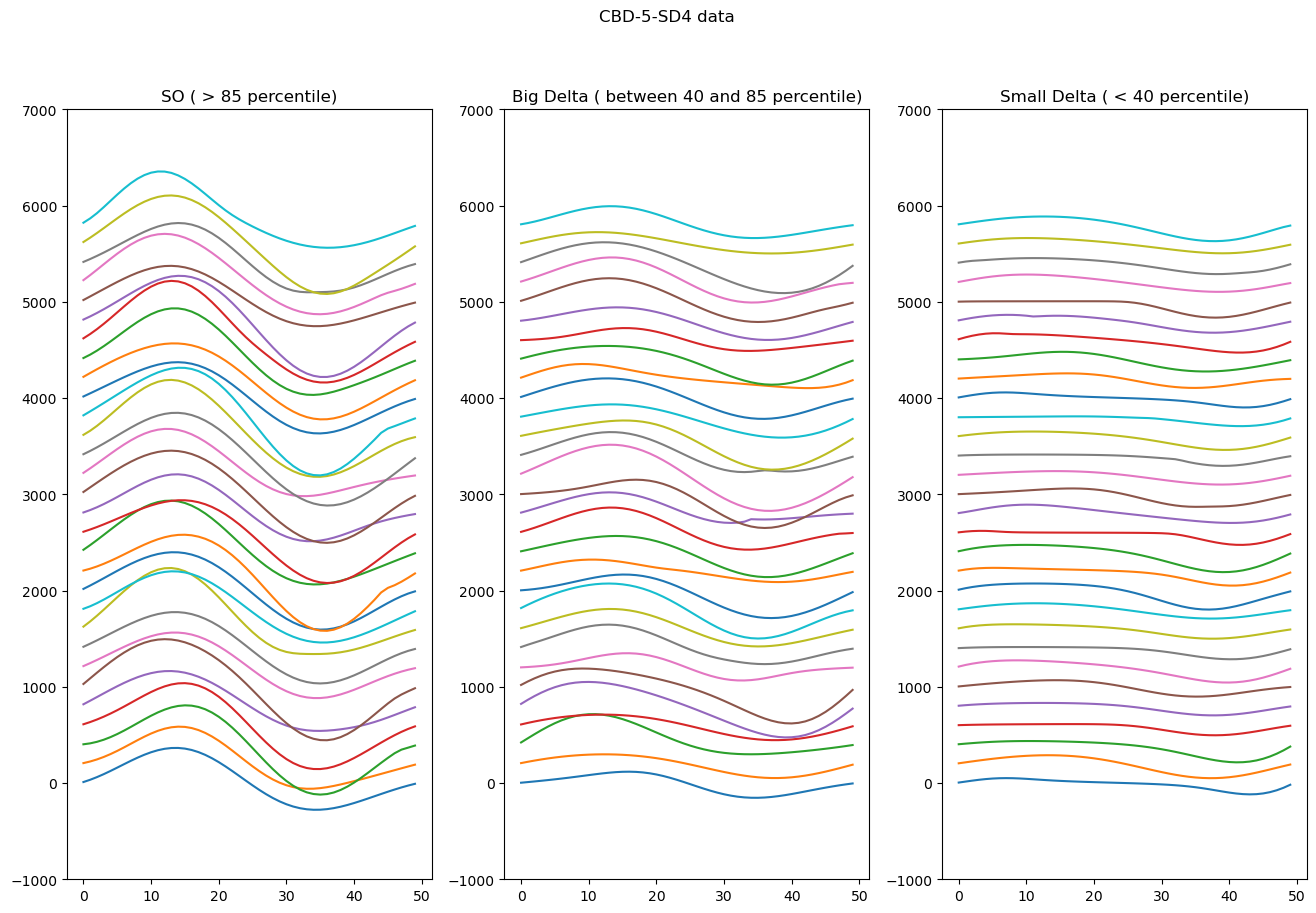

In [183]:
plt.figure(figsize=(16,10), facecolor='white')
plt.suptitle("CBD-5-SD4 data")
plt.subplot(1, 3, 1)
plt.title('SO ( > 85 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, CBD_so_waveforms_trial5.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(CBD_so_waveforms_trial5[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

# plt.subplot(1, 4, 2)
# plt.title('Delta (< 85 percentile)')
# # plt.yticks([])
# start = 0
# cycles_to_plot = np.random.randint(1, OS_delta_waveforms_trial5.shape[1], 30)
# for i in cycles_to_plot:
#   plt.plot(OS_delta_waveforms_trial5[:,i]+start)
#   start += 200
# plt.ylim((-1000, 7000))

plt.subplot(1, 3, 2)
plt.title('Big Delta ( between 40 and 85 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, CBD_big_delta_waveforms_trial5.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(CBD_big_delta_waveforms_trial5[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

plt.subplot(1, 3, 3)
plt.title('Small Delta ( < 40 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, CBD_small_delta_waveforms_trial5.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(CBD_small_delta_waveforms_trial5[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

# plt.savefig('Phase-align-cycles.svg')

# Get cycle subsets according to Thresholds (RGS)

In [80]:
path_to_data = './data/RGS_13_SD4/'
data_file = 'Cleaned_Trial1_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-21_11-29-11_Post-Trial1-states.mat'
pfc_data1, sleep_scoring1 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial2_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-21_12-19-45_Post-Trial2-states.mat'
pfc_data2, sleep_scoring2 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial3_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-21_13-11-00_Post-Trial3-states.mat'
pfc_data3, sleep_scoring3 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial4_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-21_14-01-51_Post-Trial4-states.mat'
pfc_data4, sleep_scoring4 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial5_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-21_14-56-02_Post-trial5-states.mat'
pfc_data5, sleep_scoring5 = load_mat_data(path_to_data, data_file, states_file)

In [81]:
len(pfc_data5)/len(sleep_scoring5)

1000.0896844436243

In [98]:
def get_delta_cycles(pfc_data, sleep_scoring, fs=1000):
    # Get filtered NREM LFP data
    nrem_epochs = np.array(get_all_NREM_epochs(sleep_scoring))
    if len(nrem_epochs) == 0:
        return {}
    nrem_filtered_data, nrem_data = get_nrem_filtered(pfc_data, nrem_epochs, fs=fs)

    # Get cycles using IP
    IP, IF, IA = emd.spectra.frequency_transform(nrem_filtered_data, fs, 'hilbert')
    C = emd.cycles.Cycles(IP)
    cycles = get_cycles_with_metrics(C, nrem_filtered_data, IA, IF)
    
    delta_cycle_data = {"fs": fs, 'nrem_epochs': nrem_epochs, 'nrem_filtered_data': nrem_filtered_data,
                       "IP": IP, "IF": IF, "IP": IP, "cycles": cycles}
    return delta_cycle_data

def get_nrem_filtered(pfc_data, nrem_epochs, fs):
    nrem_data = []
    for start, end in nrem_epochs:
        pfc_data_part = pfc_data[start*fs:end*fs]
        nrem_data.extend(pfc_data_part)
    nrem_data = np.array(nrem_data)
    nrem_filtered_data = filter_signal(nrem_data, fs, 'bandpass', (0.1, 4), filter_type='iir', butterworth_order=6, remove_edges=False)
    return nrem_filtered_data, nrem_data

In [96]:
RGS_delta_cycle_data_trial1 = get_delta_cycles(pfc_data1, sleep_scoring1, fs=1000)
RGS_delta_cycle_data_trial2 = get_delta_cycles(pfc_data2, sleep_scoring2, fs=1000)
RGS_delta_cycle_data_trial3 = get_delta_cycles(pfc_data3, sleep_scoring3, fs=1000)
RGS_delta_cycle_data_trial4 = get_delta_cycles(pfc_data4, sleep_scoring4, fs=1000)
RGS_delta_cycle_data_trial5 = get_delta_cycles(pfc_data5, sleep_scoring5, fs=1000)

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'


In [238]:
# metrics1 = RGS_delta_cycle_data_trial1['cycles'].get_metric_dataframe()
metrics2 = RGS_delta_cycle_data_trial2['cycles'].get_metric_dataframe()
metrics3 = RGS_delta_cycle_data_trial3['cycles'].get_metric_dataframe()
metrics4 = RGS_delta_cycle_data_trial4['cycles'].get_metric_dataframe()
metrics5 = RGS_delta_cycle_data_trial5['cycles'].get_metric_dataframe()

RGS_all_trials_metrics = pd.concat([metrics2, metrics3, metrics4, metrics5])
# all_trials_metrics = metrics5

trough = 60
peak = 90
delta_peak = 60

peak_thresh = np.percentile(RGS_all_trials_metrics['peak_values'], peak)
trough_thresh = np.percentile(RGS_all_trials_metrics['trough_values'], trough)
delta_peak_thresh = np.percentile(RGS_all_trials_metrics['peak_values'], delta_peak)

lo_freq_duration = RGS_delta_cycle_data_trial5['fs']/0.1
hi_freq_duration = RGS_delta_cycle_data_trial5['fs']/4

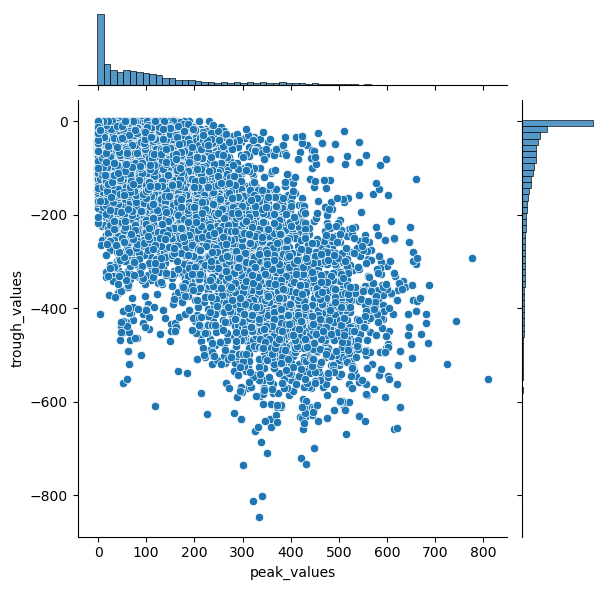

In [239]:
sns.jointplot(x=RGS_all_trials_metrics['peak_values'], y=RGS_all_trials_metrics['trough_values'])

In [240]:
# Apply conditions to get good cycles
conditions_all_cycles = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'trough_values<={trough_thresh}']

conditions_so_cycles = ['is_good==1',
          f'duration_samples<{lo_freq_duration}',
          f'duration_samples>{hi_freq_duration}',
          f'peak_values>={peak_thresh}',
          f'trough_values<={trough_thresh}']

conditions_delta_cycles = ['is_good==1',
          f'duration_samples<{lo_freq_duration}',
          f'duration_samples>{hi_freq_duration}',
          f'peak_values<{peak_thresh}',
          f'trough_values<={trough_thresh}']

# all_cycles_trial1 = get_cycles_with_conditions(delta_cycle_data_trial1['cycles'], conditions_all_cycles)
# all_cycles_trial2 = get_cycles_with_conditions(delta_cycle_data_trial2['cycles'], conditions_all_cycles)
# all_cycles_trial3 = get_cycles_with_conditions(delta_cycle_data_trial3['cycles'], conditions_all_cycles)
# all_cycles_trial4 = get_cycles_with_conditions(delta_cycle_data_trial4['cycles'], conditions_all_cycles)
RGS_all_cycles_trial5 = get_cycles_with_conditions(RGS_delta_cycle_data_trial5['cycles'], conditions_all_cycles)

# so_cycles_trial1 = get_cycles_with_conditions(delta_cycle_data_trial1['cycles'], conditions_so_cycles)
# so_cycles_trial2 = get_cycles_with_conditions(delta_cycle_data_trial2['cycles'], conditions_so_cycles)
# so_cycles_trial3 = get_cycles_with_conditions(delta_cycle_data_trial3['cycles'], conditions_so_cycles)
# so_cycles_trial4 = get_cycles_with_conditions(delta_cycle_data_trial4['cycles'], conditions_so_cycles)
RGS_so_cycles_trial5 = get_cycles_with_conditions(RGS_delta_cycle_data_trial5['cycles'], conditions_so_cycles)

# delta_cycles_trial1 = get_cycles_with_conditions(delta_cycle_data_trial1['cycles'], conditions_delta_cycles)
# delta_cycles_trial2 = get_cycles_with_conditions(delta_cycle_data_trial2['cycles'], conditions_delta_cycles)
# delta_cycles_trial3 = get_cycles_with_conditions(delta_cycle_data_trial3['cycles'], conditions_delta_cycles)
# delta_cycles_trial4 = get_cycles_with_conditions(delta_cycle_data_trial4['cycles'], conditions_delta_cycles)
RGS_delta_cycles_trial5 = get_cycles_with_conditions(RGS_delta_cycle_data_trial5['cycles'], conditions_delta_cycles)

In [241]:
conditions_big_delta_cycles = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              f'peak_values>{delta_peak_thresh}']

conditions_small_delta_cycles = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              f'peak_values<={delta_peak_thresh}']

RGS_big_delta_cycles_trial5 = get_cycles_with_conditions(RGS_delta_cycles_trial5, conditions_big_delta_cycles)
RGS_small_delta_cycles_trial5 = get_cycles_with_conditions(RGS_delta_cycles_trial5, conditions_small_delta_cycles)

## Phase-aligned Cycles

In [242]:
# all_waveforms_trial1, _ = emd.cycles.phase_align(delta_cycle_data_trial1['IP'], delta_cycle_data_trial1['nrem_filtered_data'],
#                                                             cycles=all_cycles_trial1.iterate(through='subset'), npoints=100)
# all_waveforms_trial2, _ = emd.cycles.phase_align(delta_cycle_data_trial2['IP'], delta_cycle_data_trial2['nrem_filtered_data'],
#                                                             cycles=all_cycles_trial2.iterate(through='subset'), npoints=100)
# all_waveforms_trial3, _ = emd.cycles.phase_align(delta_cycle_data_trial3['IP'], delta_cycle_data_trial3['nrem_filtered_data'],
#                                                             cycles=all_cycles_trial3.iterate(through='subset'), npoints=100)
# all_waveforms_trial4, _ = emd.cycles.phase_align(delta_cycle_data_trial4['IP'], delta_cycle_data_trial4['nrem_filtered_data'],
#                                                             cycles=all_cycles_trial4.iterate(through='subset'), npoints=100)
RGS_all_waveforms_trial5, _ = emd.cycles.phase_align(RGS_delta_cycle_data_trial5['IP'], RGS_delta_cycle_data_trial5['nrem_filtered_data'],
                                                            cycles=RGS_all_cycles_trial5.iterate(through='subset'), npoints=50)


# so_waveforms_trial1, _ = emd.cycles.phase_align(delta_cycle_data_trial1['IP'], delta_cycle_data_trial1['nrem_filtered_data'],
#                                                             cycles=so_cycles_trial1.iterate(through='subset'), npoints=100)
# so_waveforms_trial2, _ = emd.cycles.phase_align(delta_cycle_data_trial2['IP'], delta_cycle_data_trial2['nrem_filtered_data'],
#                                                             cycles=so_cycles_trial2.iterate(through='subset'), npoints=100)
# so_waveforms_trial3, _ = emd.cycles.phase_align(delta_cycle_data_trial3['IP'], delta_cycle_data_trial3['nrem_filtered_data'],
#                                                             cycles=so_cycles_trial3.iterate(through='subset'), npoints=100)
# so_waveforms_trial4, _ = emd.cycles.phase_align(delta_cycle_data_trial4['IP'], delta_cycle_data_trial4['nrem_filtered_data'],
#                                                             cycles=so_cycles_trial4.iterate(through='subset'), npoints=100)
RGS_so_waveforms_trial5, _ = emd.cycles.phase_align(RGS_delta_cycle_data_trial5['IP'], RGS_delta_cycle_data_trial5['nrem_filtered_data'],
                                                            cycles=RGS_so_cycles_trial5.iterate(through='subset'), npoints=50)

# delta_waveforms_trial1, _ = emd.cycles.phase_align(delta_cycle_data_trial1['IP'], delta_cycle_data_trial1['nrem_filtered_data'],
#                                                             cycles=delta_cycles_trial1.iterate(through='subset'), npoints=100)
# delta_waveforms_trial2, _ = emd.cycles.phase_align(delta_cycle_data_trial2['IP'], delta_cycle_data_trial2['nrem_filtered_data'],
#                                                             cycles=delta_cycles_trial2.iterate(through='subset'), npoints=100)
# delta_waveforms_trial3, _ = emd.cycles.phase_align(delta_cycle_data_trial3['IP'], delta_cycle_data_trial3['nrem_filtered_data'],
#                                                             cycles=delta_cycles_trial3.iterate(through='subset'), npoints=100)
# delta_waveforms_trial4, _ = emd.cycles.phase_align(delta_cycle_data_trial4['IP'], delta_cycle_data_trial4['nrem_filtered_data'],
#                                                             cycles=delta_cycles_trial4.iterate(through='subset'), npoints=100)
RGS_delta_waveforms_trial5, _ = emd.cycles.phase_align(RGS_delta_cycle_data_trial5['IP'], RGS_delta_cycle_data_trial5['nrem_filtered_data'],
                                                            cycles=RGS_delta_cycles_trial5.iterate(through='subset'), npoints=50)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'


In [243]:
RGS_big_delta_waveforms_trial5, _ = emd.cycles.phase_align(RGS_delta_cycle_data_trial5['IP'], RGS_delta_cycle_data_trial5['nrem_filtered_data'],
                                                            cycles=RGS_big_delta_cycles_trial5.iterate(through='subset'), npoints=50)
RGS_small_delta_waveforms_trial5, _ = emd.cycles.phase_align(RGS_delta_cycle_data_trial5['IP'], RGS_delta_cycle_data_trial5['nrem_filtered_data'],
                                                            cycles=RGS_small_delta_cycles_trial5.iterate(through='subset'), npoints=50)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'


(-1000.0, 7000.0)

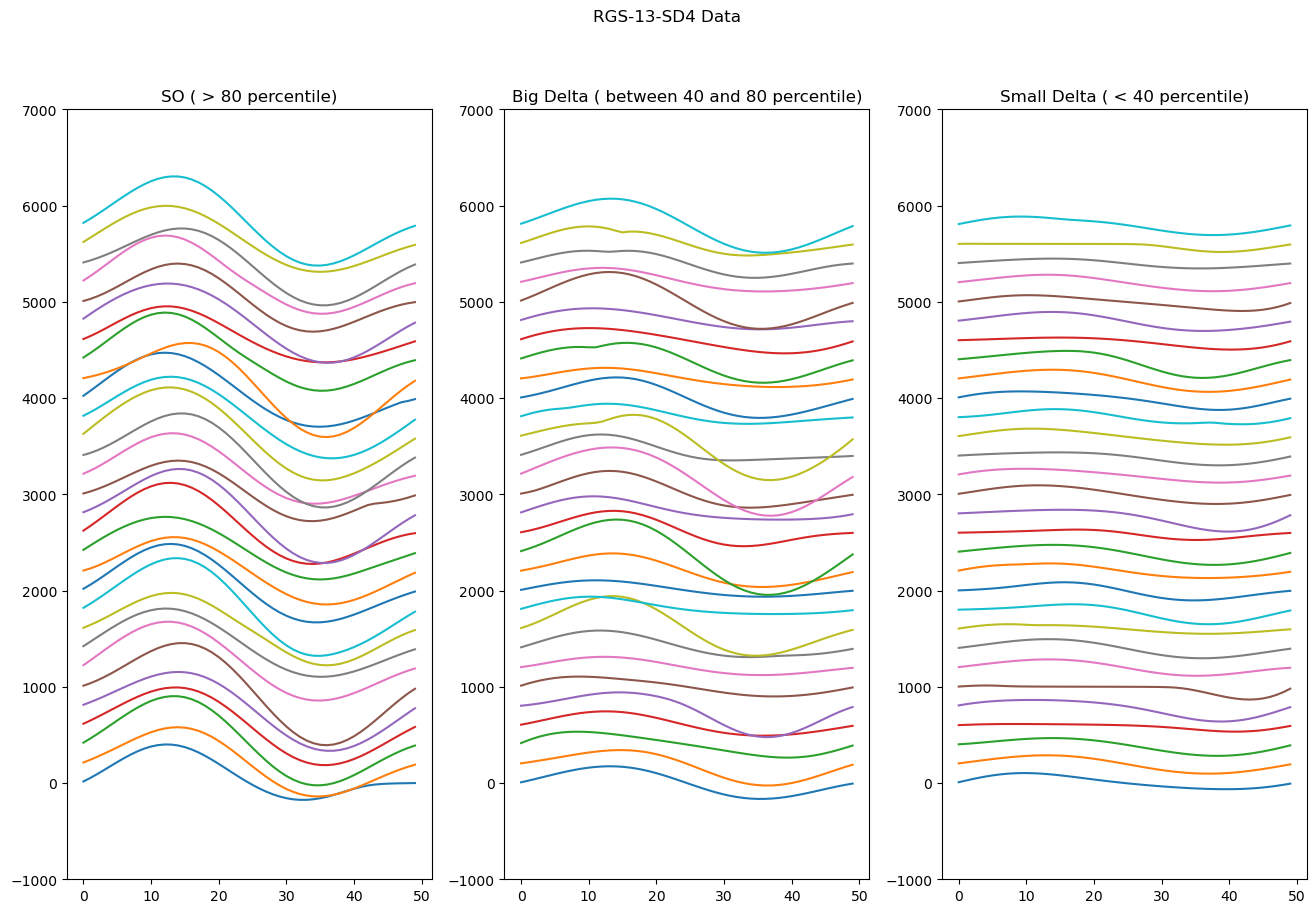

In [245]:
plt.figure(figsize=(16,10), facecolor='white')
plt.suptitle("RGS-13-SD4 Data")
plt.subplot(1, 3, 1)
plt.title('SO ( > 80 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, RGS_so_waveforms_trial5.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(RGS_so_waveforms_trial5[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

# plt.subplot(1, 4, 2)
# plt.title('Delta (< 85 percentile)')
# # plt.yticks([])
# start = 0
# cycles_to_plot = np.random.randint(1, OS_delta_waveforms_trial5.shape[1], 30)
# for i in cycles_to_plot:
#   plt.plot(OS_delta_waveforms_trial5[:,i]+start)
#   start += 200
# plt.ylim((-1000, 7000))

plt.subplot(1, 3, 2)
plt.title('Big Delta ( between 40 and 80 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, RGS_big_delta_waveforms_trial5.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(RGS_big_delta_waveforms_trial5[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

plt.subplot(1, 3, 3)
plt.title('Small Delta ( < 40 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, RGS_small_delta_waveforms_trial5.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(RGS_small_delta_waveforms_trial5[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

# plt.savefig('Phase-align-cycles.svg')